# prepare_dataset2

To prepare a new datatset for training the network for inverse kinematics.

## Step 1: Import modules

In [18]:
import os
import cv2
import sys
import glob
import time
import pickle
import threading
import numpy as np
import pandas as pd
from zeno_face_tracker_helpers import *
try:
    from ConfigParser import ConfigParser    # If using Python 2.7
except ImportError:
    from configparser import ConfigParser    # If using Python 3.5
config = ConfigParser()
config.read('config.ini')
sys.path.append(os.path.realpath(config.get('zeno_interface', 'repository_path')))
from video_sources import *
from zeno_interface import *
sys.path.append(os.path.realpath(config.get('facial_landmark_tracker', 'repository_path')))
from ibug_face_tracker import *
from zeno_face_tracker import *
print('All modules imported.')

All modules imported.


## Step 2: Get landmarks for the CK images

In [41]:
ck_data_folder = os.path.realpath('./dataset3/sorted_set_testing')
ck_images = glob.glob(os.path.join(ck_data_folder, './*/*.png'))
ck_images = [x for x in ck_images if not '_rendering.png' in x and not '_zeno.png' in x]

ert_model_path = config.get('facial_landmark_tracker', 'ert_model_path')
auxiliary_model_path = config.get('facial_landmark_tracker', 'auxiliary_model_path')
tracker = FaceTracker(ert_model_path, auxiliary_model_path)
tracker.hard_failure_threshold = -1e6
tracker.face_detection_scale = 2.0
tracker.minimum_face_size = 50

ck_data = []
for image_file in ck_images:
    image = cv2.imread(image_file)
    tracker.reset()
    tracker.track(image)
    if tracker.has_facial_landmarks:
        sample = {}
        sample['landmarks'] = tracker.facial_landmarks
        sample['eye_points'] = tracker.eye_landmarks
        sample['head_pose'] = (tracker.pitch, tracker.yaw, tracker.roll)
        sample['image_file'] = image_file
        tracker.plot_current_result(image, plot_head_pose=False)
        rendering_file = os.path.splitext(image_file)[0] + '_rendering.png'
        cv2.imwrite(rendering_file, image)
        ck_data.append(sample)
print('Done')

Done


In [42]:
with open('model.pkl', 'rb') as model_file:
    model = pickle.load(model_file)

anchors = [int(x) for x in config.get('data_organisation', 'alignment_anchors').strip().replace(
    ' ', '').replace('\'', '').replace('\"', '').split(',') if len(x) > 0]

for sample in ck_data:
    left_iris = sample['eye_points'][1:6].mean(axis=0)
    right_iris = sample['eye_points'][8:13].mean(axis=0)
    all_landmarks = np.vstack((sample['landmarks'], left_iris, right_iris))
    
    transform = compute_rigid_alignment_parameters(all_landmarks[anchors], 
                                                   model['mean_shape'][anchors])
    aligned_landmarks = apply_rigid_alignment_parameters(all_landmarks, *transform)
    displacement = aligned_landmarks - model['neutral_shape']

    flattened_displacement = np.divide(displacement.flatten() - model['multipie_mean'], model['multipie_std'])
    flattened_displacement_recon = np.matmul(np.matmul(flattened_displacement, 
                                                       model['multipie_pca_basis']), 
                                             model['multipie_pca_basis'].T)
    feature = np.matmul(flattened_displacement_recon, model['pca_basis'])
    sample['actuator_values'] = np.matmul(feature.tolist() + [1], model['lr_coefs'][0])

## Step 3: Collect data

In [43]:
zeno_head = None
video_source = None
config.read('config.ini')
motor_duration = config.getint('zeno_interface', 'motor_duration')
grace_period = config.getint('zeno_interface', 'grace_period')
try:
    # Load configuration related to data collection
    sampling_delay = config.getint('prepare_dataset2', 'sampling_delay') / 1000.0 / 2
    retry_limit = max(1, config.getint('prepare_dataset2', 'retry_limit'))

    # Connect to the robot
    zeno_ip_address = config.get('zeno_interface', 'zeno_ip_address')
    zeno_head = ZenoHead(zeno_ip_address)
    print('Connected to zeno at %s.' % zeno_ip_address)
    
    # Initialise the tracker
    tracker68 = ZenoFaceTracker(os.path.realpath('./models/zeno_landmark_tracker_68.model'), 
                                os.path.realpath(config.get('facial_landmark_tracker', 'auxiliary_model_path')), 
                                os.path.realpath('./models/zeno_face_detector.model'))
    tracker68.failure_detection_interval = 1
    print('Lanmark tracker initialised.')

    # Open the video source
    video_source_id = config.get('video_source', 'video_source')
    frame_width = config.getint('video_source', 'frame_width')
    frame_height = config.getint('video_source', 'frame_height')
    frame_rate = config.getfloat('video_source', 'frame_rate')
    if video_source_id == 'window':
        window_title_re = config.get('window_specification', 'title_re')
        window_class_name = config.get('window_specification', 'class_name')
        child_identifier = config.get('window_specification', 'child_identifier')
        window_roi = config.get('window_specification', 'window_roi').replace(
            '\'', '').replace('\"', '').replace('\t', '').replace(' ', '')
        window_roi = tuple([float(x) for x in window_roi.split(',') if len(x) > 0])
        pywinauto = importlib.import_module('pywinauto')
        top_level_window = pywinauto.Desktop(backend='win32').window(title_re=window_title_re,
                                                                     class_name=window_class_name,
                                                                     visible_only=False)
        if len(child_identifier) > 0:
            window_handle = top_level_window[child_identifier].handle
        else:
            window_handle = top_level_window.handle
            video_source = ThreadedWindowCapture(window_handle, frame_width, frame_height, 
                                                 frame_rate, window_roi)
            print('Window capture initialised.')
    else:
        video_source = ThreadedWebcam(int(video_source_id), frame_width, frame_height, frame_rate)
        print('Webcam #%d opened.' % int(video_source_id))
    
    # The processing loop
    cv2.namedWindow('68 landmark model', cv2.WINDOW_GUI_NORMAL | cv2.WINDOW_KEEPRATIO)
    cv2.resizeWindow('68 landmark model', (frame_width, frame_height))    
    for idx, sample in enumerate(ck_data):
        cv2.imshow('source', cv2.imread(os.path.splitext(sample['image_file'])[0] + '_rendering.png'))
        zeno_head.move(np.clip(sample['actuator_values'], 0.0, 1.0), motor_duration)
        last_move_time = time.time()
        retries = 0
        while cv2.getWindowProperty('68 landmark model', 0) >= 0:
            is_new_frame, frame = video_source.read(0.01)
            if is_new_frame:
                if frame is None:
                    break
                else:
                    tracker68.track(frame)
                    rendering = frame.copy()
                    tracker68.plot_current_result(rendering, plot_head_pose=False)
                    cv2.imshow('68 landmark model', rendering)
                    time_elapsed = time.time() - last_move_time
                    if time_elapsed >= sampling_delay:
                        if tracker68.has_facial_landmarks:
                            sample['zeno_eye_points'] = tracker68.eye_landmarks
                            sample['zeno_landmarks'] = tracker68.facial_landmarks
                            cv2.imwrite(os.path.splitext(sample['image_file'])[0] + '_zeno.png', frame)
                            cv2.imwrite(os.path.splitext(sample['image_file'])[0] + '_zeno_rendering.png', rendering)
                            print('%d of %d samples captured.' % (idx + 1, len(ck_data)))
                        else:
                            retries = retries + 1
                        if tracker68.has_facial_landmarks or retries >= retry_limit:
                            break
                    elif time_elapsed >= motor_duration / 1000.0:
                        # Hold current position
                        zeno_head.move(np.clip(sample['actuator_values'], 0.0, 1.0), 40)
            cv2.waitKey(10)
finally:
    cv2.destroyAllWindows()
    if video_source is not None:
        video_source.release()
    if zeno_head is not None:
        zeno_head.reset(motor_duration)
        time.sleep(max(motor_duration, grace_period) / 1000.0)
        zeno_head.disconnect()
    print('We are done here.')

Connected to zeno at 127.0.0.1.
Lanmark tracker initialised.
Webcam #0 opened.
1 of 365 samples captured.
2 of 365 samples captured.
3 of 365 samples captured.
4 of 365 samples captured.
5 of 365 samples captured.
6 of 365 samples captured.
7 of 365 samples captured.
8 of 365 samples captured.
9 of 365 samples captured.
10 of 365 samples captured.
11 of 365 samples captured.
12 of 365 samples captured.
13 of 365 samples captured.
14 of 365 samples captured.
15 of 365 samples captured.
16 of 365 samples captured.
17 of 365 samples captured.
18 of 365 samples captured.
19 of 365 samples captured.
20 of 365 samples captured.
21 of 365 samples captured.
22 of 365 samples captured.
23 of 365 samples captured.
24 of 365 samples captured.
25 of 365 samples captured.
26 of 365 samples captured.
27 of 365 samples captured.
28 of 365 samples captured.
29 of 365 samples captured.
30 of 365 samples captured.
31 of 365 samples captured.
32 of 365 samples captured.
33 of 365 samples captured.
34 of 

285 of 365 samples captured.
286 of 365 samples captured.
287 of 365 samples captured.
288 of 365 samples captured.
289 of 365 samples captured.
290 of 365 samples captured.
291 of 365 samples captured.
292 of 365 samples captured.
293 of 365 samples captured.
294 of 365 samples captured.
295 of 365 samples captured.
296 of 365 samples captured.
297 of 365 samples captured.
298 of 365 samples captured.
299 of 365 samples captured.
300 of 365 samples captured.
301 of 365 samples captured.
302 of 365 samples captured.
303 of 365 samples captured.
304 of 365 samples captured.
305 of 365 samples captured.
306 of 365 samples captured.
307 of 365 samples captured.
308 of 365 samples captured.
309 of 365 samples captured.
310 of 365 samples captured.
311 of 365 samples captured.
312 of 365 samples captured.
313 of 365 samples captured.
314 of 365 samples captured.
315 of 365 samples captured.
316 of 365 samples captured.
317 of 365 samples captured.
318 of 365 samples captured.
319 of 365 sam

In [55]:
helper = ZenoHeadImitationHelper()

zeno_head = None
video_source = None
config.read('config.ini')
motor_duration = config.getint('zeno_interface', 'motor_duration')
grace_period = config.getint('zeno_interface', 'grace_period')
try:
    # Load configuration related to data collection
    sampling_delay = config.getint('prepare_dataset2', 'sampling_delay') / 1000.0 / 2
    retry_limit = max(1, config.getint('prepare_dataset2', 'retry_limit'))

    # Connect to the robot
    zeno_ip_address = config.get('zeno_interface', 'zeno_ip_address')
    zeno_head = ZenoHead(zeno_ip_address)
    print('Connected to zeno at %s.' % zeno_ip_address)
    
    # Initialise the tracker
    tracker68 = ZenoFaceTracker(os.path.realpath('./models/zeno_landmark_tracker_68.model'), 
                                os.path.realpath(config.get('facial_landmark_tracker', 'auxiliary_model_path')), 
                                os.path.realpath('./models/zeno_face_detector.model'))
    tracker68.failure_detection_interval = 1
    print('Lanmark tracker initialised.')

    # Open the video source
    video_source_id = config.get('video_source', 'video_source')
    frame_width = config.getint('video_source', 'frame_width')
    frame_height = config.getint('video_source', 'frame_height')
    frame_rate = config.getfloat('video_source', 'frame_rate')
    if video_source_id == 'window':
        window_title_re = config.get('window_specification', 'title_re')
        window_class_name = config.get('window_specification', 'class_name')
        child_identifier = config.get('window_specification', 'child_identifier')
        window_roi = config.get('window_specification', 'window_roi').replace(
            '\'', '').replace('\"', '').replace('\t', '').replace(' ', '')
        window_roi = tuple([float(x) for x in window_roi.split(',') if len(x) > 0])
        pywinauto = importlib.import_module('pywinauto')
        top_level_window = pywinauto.Desktop(backend='win32').window(title_re=window_title_re,
                                                                     class_name=window_class_name,
                                                                     visible_only=False)
        if len(child_identifier) > 0:
            window_handle = top_level_window[child_identifier].handle
        else:
            window_handle = top_level_window.handle
            video_source = ThreadedWindowCapture(window_handle, frame_width, frame_height, 
                                                 frame_rate, window_roi)
            print('Window capture initialised.')
    else:
        video_source = ThreadedWebcam(int(video_source_id), frame_width, frame_height, frame_rate)
        print('Webcam #%d opened.' % int(video_source_id))
    
    # The processing loop
    cv2.namedWindow('68 landmark model', cv2.WINDOW_GUI_NORMAL | cv2.WINDOW_KEEPRATIO)
    cv2.resizeWindow('68 landmark model', (frame_width, frame_height))    
    for idx, sample in enumerate(ck_data):
        cv2.imshow('source', cv2.imread(os.path.splitext(sample['image_file'])[0] + '_rendering.png'))
        acutator_values = helper.calculate_motor_positions(sample['landmarks'], 
                                                           sample['eye_points'], 
                                                           sample['head_pose'][0], 
                                                           sample['head_pose'][1], 
                                                           sample['head_pose'][2])
        zeno_head.move(acutator_values, motor_duration)
        last_move_time = time.time()
        retries = 0
        while cv2.getWindowProperty('68 landmark model', 0) >= 0:
            is_new_frame, frame = video_source.read(0.01)
            if is_new_frame:
                if frame is None:
                    break
                else:
                    tracker68.track(frame)
                    rendering = frame.copy()
                    tracker68.plot_current_result(rendering, plot_head_pose=False)
                    cv2.imshow('68 landmark model', rendering)
                    time_elapsed = time.time() - last_move_time
                    if time_elapsed >= sampling_delay:
                        if tracker68.has_facial_landmarks:
                            sample['old_zeno_eye_points'] = tracker68.eye_landmarks
                            sample['old_zeno_landmarks'] = tracker68.facial_landmarks
                            sample['old_actuator_values'] = acutator_values[:]
                            cv2.imwrite(os.path.splitext(sample['image_file'])[0] + '_old_zeno.png', frame)
                            cv2.imwrite(os.path.splitext(sample['image_file'])[0] + '_old_zeno_rendering.png', rendering)
                            print('%d of %d samples captured.' % (idx + 1, len(ck_data)))
                        else:
                            retries = retries + 1
                        if tracker68.has_facial_landmarks or retries >= retry_limit:
                            break
                    elif time_elapsed >= motor_duration / 1000.0:
                        # Hold current position
                        acutator_values = helper.calculate_motor_positions(sample['landmarks'], 
                                                                           sample['eye_points'], 
                                                                           sample['head_pose'][0], 
                                                                           sample['head_pose'][1], 
                                                                           sample['head_pose'][2])
                        zeno_head.move(acutator_values, 40)
            cv2.waitKey(10)
finally:
    cv2.destroyAllWindows()
    if video_source is not None:
        video_source.release()
    if zeno_head is not None:
        zeno_head.reset(motor_duration)
        time.sleep(max(motor_duration, grace_period) / 1000.0)
        zeno_head.disconnect()
    print('We are done here.')

Connected to zeno at 127.0.0.1.
Lanmark tracker initialised.
Webcam #0 opened.
1 of 365 samples captured.
2 of 365 samples captured.
3 of 365 samples captured.
4 of 365 samples captured.
5 of 365 samples captured.
6 of 365 samples captured.
7 of 365 samples captured.
8 of 365 samples captured.
9 of 365 samples captured.
10 of 365 samples captured.
11 of 365 samples captured.
12 of 365 samples captured.
13 of 365 samples captured.
14 of 365 samples captured.
15 of 365 samples captured.
16 of 365 samples captured.
17 of 365 samples captured.
18 of 365 samples captured.
19 of 365 samples captured.
20 of 365 samples captured.
21 of 365 samples captured.
22 of 365 samples captured.
23 of 365 samples captured.
24 of 365 samples captured.
25 of 365 samples captured.
26 of 365 samples captured.
27 of 365 samples captured.
28 of 365 samples captured.
29 of 365 samples captured.
30 of 365 samples captured.
31 of 365 samples captured.
32 of 365 samples captured.
33 of 365 samples captured.
34 of 

285 of 365 samples captured.
286 of 365 samples captured.
287 of 365 samples captured.
288 of 365 samples captured.
289 of 365 samples captured.
290 of 365 samples captured.
291 of 365 samples captured.
292 of 365 samples captured.
293 of 365 samples captured.
294 of 365 samples captured.
295 of 365 samples captured.
296 of 365 samples captured.
297 of 365 samples captured.
298 of 365 samples captured.
299 of 365 samples captured.
300 of 365 samples captured.
301 of 365 samples captured.
302 of 365 samples captured.
303 of 365 samples captured.
304 of 365 samples captured.
305 of 365 samples captured.
306 of 365 samples captured.
307 of 365 samples captured.
308 of 365 samples captured.
309 of 365 samples captured.
310 of 365 samples captured.
311 of 365 samples captured.
312 of 365 samples captured.
313 of 365 samples captured.
314 of 365 samples captured.
315 of 365 samples captured.
316 of 365 samples captured.
317 of 365 samples captured.
318 of 365 samples captured.
319 of 365 sam

In [56]:
pd.DataFrame(ck_data).to_pickle('ck_data.pkl', protocol=2)

In [69]:
def get_face_box(landmarks, margin=(0.0, 0.0, 0.0, 0.0), exclude_chin_points=False):
    # Get bounding box
    if exclude_chin_points and landmarks.shape[0] == 68:
        top_left = np.min(landmarks[17:], axis=0)
        bottom_right = np.max(landmarks[17:], axis=0)
    else:
        top_left = np.min(landmarks, axis=0)
        bottom_right = np.max(landmarks, axis=0)
    face_size = bottom_right - top_left
    top_left[0] = np.floor(top_left[0] - face_size[0] * margin[0])
    top_left[1] = np.floor(top_left[1] - face_size[1] * margin[1])
    bottom_right[0] = np.ceil(bottom_right[0] + face_size[0] * margin[2])
    bottom_right[1] = np.ceil(bottom_right[1] + face_size[1] * margin[3])

    # Make face box square
    difference = (bottom_right[1] - top_left[1] + 1) - (bottom_right[0] - top_left[0] + 1)
    if difference > 0:
        top_left[0] -= difference // 2
        bottom_right[0] += difference - difference // 2
    elif difference < 0:
        difference = -difference
        top_left[1] -= difference // 2
        bottom_right[1] += difference - difference // 2

    return top_left, bottom_right


def extract_face_image(image, landmarks, target_size, margin, head_pose=None,
                       eye_points=None, exclude_chin_points=False,
                       interpolation=cv2.INTER_CUBIC):
    # First, see whether we have head pose
    if head_pose is not None and len(head_pose) >= 3:
        roll = head_pose[2]
    else:
        roll = None

    # Get a proper bounding box for the face
    if margin is None:
        margin = (0.0, 0.0, 0.0, 0.0)
    if roll is None:
        top_left, bottom_right = get_face_box(landmarks, margin, exclude_chin_points)
    else:
        rotated_landmarks = cv2.getRotationMatrix2D((0, 0), roll, 1.0).dot(
            np.vstack((landmarks.T, np.ones(landmarks.shape[0])))).T
        top_left, bottom_right = get_face_box(rotated_landmarks, margin, exclude_chin_points)
        corners = np.array([[top_left[0], top_left[1], 1],
                            [bottom_right[0], top_left[1], 1],
                            [bottom_right[0], bottom_right[1], 1],
                            [top_left[0], bottom_right[1], 1]])
        top_left, bottom_right = get_face_box(cv2.getRotationMatrix2D(
            (0, 0), -roll, 1.0).dot(corners.T).T, (0, 0, 0, 0), exclude_chin_points)
        top_left -= 5
        bottom_right += 5

    # Enlarge the image if necessary
    padding = np.zeros((image.ndim, 2), dtype=int)
    if top_left[0] < 0:
        padding[1][0] = -int(top_left[0])
    if top_left[1] < 0:
        padding[0][0] = -int(top_left[1])
    if bottom_right[0] >= image.shape[1]:
        padding[1][1] = int(bottom_right[0] - image.shape[1] + 1)
    if bottom_right[1] >= image.shape[0]:
        padding[0][1] = int(bottom_right[1] - image.shape[0] + 1)
    image = np.pad(image, padding, 'symmetric')

    # Revise bounding box and landmarks accordingly
    landmarks = landmarks.copy()
    if eye_points is not None:
        eye_points = eye_points.copy()
    if top_left[0] < 0:
        bottom_right[0] -= top_left[0]
        landmarks[:, 0] -= top_left[0]
        if eye_points is not None:
            eye_points[:, 0] -= top_left[0]
        top_left[0] = 0
    if top_left[1] < 0:
        bottom_right[1] -= top_left[1]
        landmarks[:, 1] -= top_left[1]
        if eye_points is not None:
            eye_points[:, 1] -= top_left[1]
        top_left[1] = 0

    # Extract the face image
    face_image = image[int(top_left[1]): int(bottom_right[1] + 1),
                       int(top_left[0]): int(bottom_right[0] + 1)]
    landmarks[:, 0] -= top_left[0]
    landmarks[:, 1] -= top_left[1]
    if eye_points is not None:
        eye_points[:, 0] -= top_left[0]
        eye_points[:, 1] -= top_left[1]

    # If head pose is given, rotate everything
    if roll is not None:
        rotation_matrix = cv2.getRotationMatrix2D(((face_image.shape[1] - 1) / 2.0,
                                                   (face_image.shape[0] - 1) / 2.0), roll, 1.0)
        face_image = cv2.warpAffine(face_image, rotation_matrix,
                                    dsize=(face_image.shape[1], face_image.shape[0]),
                                    flags=(interpolation + cv2.WARP_FILL_OUTLIERS))
        landmarks = rotation_matrix.dot(np.vstack((landmarks.T, np.ones(landmarks.shape[0])))).T
        if eye_points is not None:
            eye_points = rotation_matrix.dot(np.vstack((eye_points.T, np.ones(eye_points.shape[0])))).T
        top_left, bottom_right = get_face_box(landmarks, margin, exclude_chin_points)
        if top_left[0] > 0:
            landmarks[:, 0] -= top_left[0]
            if eye_points is not None:
                eye_points[:, 0] -= top_left[0]
        if top_left[1] > 0:
            landmarks[:, 1] -= top_left[1]
            if eye_points is not None:
                eye_points[:, 1] -= top_left[1]
        face_image = face_image[max(int(top_left[1]), 0): min(int(bottom_right[1] + 1), face_image.shape[0]),
                                max(int(top_left[0]), 0): min(int(bottom_right[0] + 1), face_image.shape[1])]

    # Rescale landmarks and face image
    if target_size is not None and target_size[0] > 0 and target_size[1] > 0:
        landmarks[:, 0] *= float(target_size[0]) / max(face_image.shape[1], 1)
        landmarks[:, 1] *= float(target_size[1]) / max(face_image.shape[0], 1)
        if eye_points is not None:
            eye_points[:, 0] *= float(target_size[0]) / max(face_image.shape[1], 1)
            eye_points[:, 1] *= float(target_size[1]) / max(face_image.shape[0], 1)
        face_image = cv2.resize(face_image, target_size, interpolation=interpolation)
    else:
        face_image = face_image.copy()

    return face_image, landmarks, eye_points

In [79]:
# Extra face images from the recording
for sample in ck_data:
    
    new_face_file = sample['image_file'].replace('sorted_set_testing', 'sorted_set_testing_zeno')
    new_face_folder = os.path.dirname(new_face_file)
    if not os.path.exists(new_face_folder):
        os.makedirs(new_face_folder)
    image = cv2.imread(os.path.splitext(sample['image_file'])[0] + '_zeno.png')
    new_face = extract_face_image(image, sample['zeno_landmarks'], (300, 300), (0.05, 0.1, 0.05, 0.1))[0]
    cv2.imwrite(new_face_file, new_face)
    
    old_face_file = sample['image_file'].replace('sorted_set_testing', 'sorted_set_testing_zeno_old')
    old_face_folder = os.path.dirname(old_face_file)
    if not os.path.exists(old_face_folder):
        os.makedirs(old_face_folder)
    image = cv2.imread(os.path.splitext(sample['image_file'])[0] + '_old_zeno.png')
    old_face = extract_face_image(image, sample['old_zeno_landmarks'], (300, 300), (0.05, 0.1, 0.05, 0.1))[0]
    cv2.imwrite(old_face_file, old_face)

In [106]:
# Compare displacement?
for sample in ck_data:
    
    # Calculate displacement on human face
    left_iris = sample['eye_points'][1:6].mean(axis=0)
    right_iris = sample['eye_points'][8:13].mean(axis=0)
    all_landmarks = np.vstack((sample['landmarks'], left_iris, right_iris))
    transform = compute_rigid_alignment_parameters(all_landmarks[anchors], 
                                                   model['mean_shape'][anchors])
    aligned_landmarks = apply_rigid_alignment_parameters(all_landmarks, *transform)
    sample['displacement'] = aligned_landmarks - model['neutral_shape']
    
    # Calculate displacement on zeno face
    left_iris = sample['zeno_eye_points'][1:6].mean(axis=0)
    right_iris = sample['zeno_eye_points'][8:13].mean(axis=0)
    all_landmarks = np.vstack((sample['zeno_landmarks'], left_iris, right_iris))
    transform = compute_rigid_alignment_parameters(all_landmarks[anchors], 
                                                   model['zeno_mean_shape'][anchors])
    aligned_landmarks = apply_rigid_alignment_parameters(all_landmarks, *transform)
    sample['zeno_displacement'] = aligned_landmarks - model['zeno_neutral_shape']
    sample['zeno_displacement_difference'] = np.mean([np.linalg.norm(x) for x in 
                                                      sample['zeno_displacement'] - 
                                                      sample['displacement']])
    
    # Calculate displacement on zeno face for the old method
    left_iris = sample['old_zeno_eye_points'][1:6].mean(axis=0)
    right_iris = sample['old_zeno_eye_points'][8:13].mean(axis=0)
    all_landmarks = np.vstack((sample['old_zeno_landmarks'], left_iris, right_iris))
    transform = compute_rigid_alignment_parameters(all_landmarks[anchors], 
                                                   model['zeno_mean_shape'][anchors])
    aligned_landmarks = apply_rigid_alignment_parameters(all_landmarks, *transform)
    sample['old_zeno_displacement'] = aligned_landmarks - model['zeno_neutral_shape']
    sample['old_zeno_displacement_difference'] = np.mean([np.linalg.norm(x) for x in 
                                                          sample['old_zeno_displacement'] - 
                                                          sample['displacement']])

In [133]:
zeno_d_outer = np.linalg.norm(model['zeno_neutral_shape'][36] - model['zeno_neutral_shape'][45])
new_displacement_error = [x['zeno_displacement_difference'] / zeno_d_outer * 85.0 for x in ck_data]
old_displacement_error = [x['old_zeno_displacement_difference'] / zeno_d_outer * 85.0 for x in ck_data]

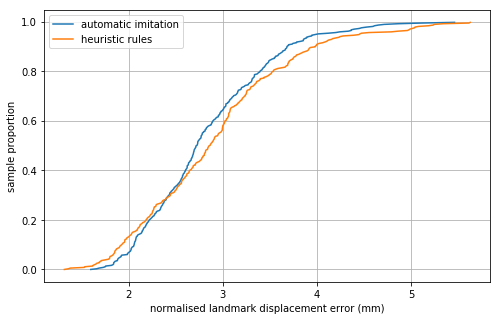

2.8301009082419992
0.6684607259245723
2.9131986870210227
0.8180639220572737


In [159]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt

matplotlib.rcParams['figure.figsize'] = [8, 5]

plt.plot(sorted(new_displacement_error), np.arange(len(new_displacement_error)) / 
         float(len(new_displacement_error)), label='automatic imitation')
plt.plot(sorted(old_displacement_error), np.arange(len(old_displacement_error)) / 
         float(len(old_displacement_error)), label='heuristic rules')
plt.legend()
plt.grid(which='both')
plt.xlabel('normalised landmark displacement error (mm)')
plt.ylabel('sample proportion')
plt.show()

print(np.mean(new_displacement_error))
print(np.std(lala1) / zeno_d_outer * 85)

print(np.mean(lala2) / zeno_d_outer * 85)
print(np.std(lala2) / zeno_d_outer * 85)


In [122]:
zeno_d_outer

0.5504235530492284